In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip '/content/drive/My Drive/flowers/flower_data.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: flower_data/train/50/image_06553.jpg  
  inflating: flower_data/train/50/image_06554.jpg  
  inflating: flower_data/train/50/image_06555.jpg  
  inflating: flower_data/train/50/image_06556.jpg  
  inflating: flower_data/train/50/image_06557.jpg  
  inflating: flower_data/train/50/image_06559.jpg  
  inflating: flower_data/train/50/image_06560.jpg  
  inflating: flower_data/train/50/image_06561.jpg  
  inflating: flower_data/train/50/image_06563.jpg  
  inflating: flower_data/train/50/image_06564.jpg  
  inflating: flower_data/train/50/image_06565.jpg  
  inflating: flower_data/train/50/image_06566.jpg  
  inflating: flower_data/train/50/image_06567.jpg  
  inflating: flower_data/train/50/image_06568.jpg  
  inflating: flower_data/train/50/image_06569.jpg  
  inflating: flower_data/train/50/image_06570.jpg  
   creating: flower_data/train/51/
  inflating: flower_data/train/51/image_01317.jpg  
  inflating: 

In [4]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.6 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import InputLayer, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Read json file**

In [15]:
import json

# Replace 'your_file_name.json' with the path to your uploaded JSON file
file_path = 'flower_data/cat_to_name.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Now 'data' is a Python dictionary containing the contents of the JSON file
print(data)


{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

**Data augmentation and preprocessing**

In [6]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/flower_data/train'
test_dir = '/content/flower_data/valid'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # Use 20% of training data for validation

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')


Found 5283 images belonging to 102 classes.
Found 1269 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


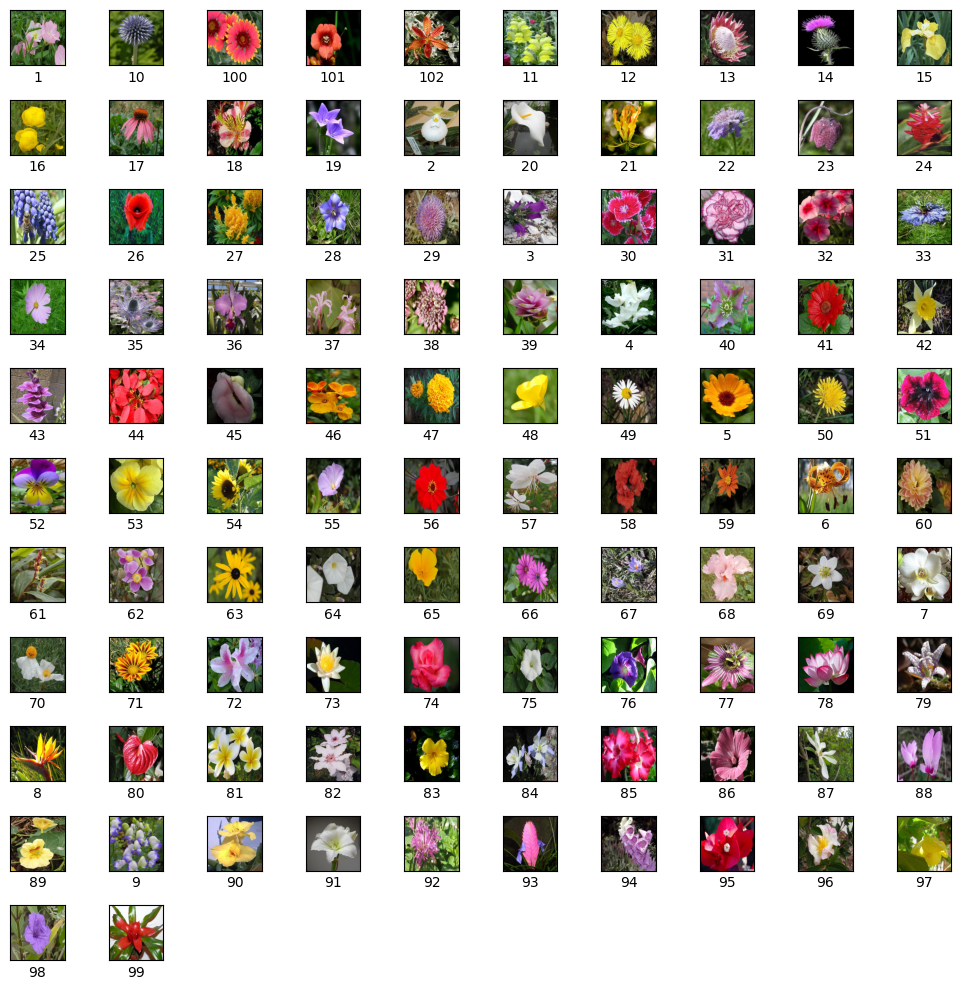

In [23]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

train_dir = '/content/flower_data/train'

class_names = os.listdir(train_dir)
class_names.sort()

plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):

    class_files = os.listdir(os.path.join(train_dir, class_name))

    if class_files:
        first_image_file = class_files[0]

        img_path = os.path.join(train_dir, class_name, first_image_file)

        img = image.load_img(img_path, target_size=(224, 224))

        plt.subplot(len(class_names)//10 + 1, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
        plt.xlabel(class_name)
    else:
        print(f"No images found in {class_name}.")

#Show all classes
plt.tight_layout()
plt.show()


**Model - EfficientNet**

In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Custom layers on top for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


16705208/16705208 [==============================] - 0s 0us/step


In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


**Train frozen based model**

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)


Epoch 1/5
165/165 [==============================] - 111s 602ms/step - loss: 4.5588 - accuracy: 0.0253 - val_loss: 4.5117 - val_accuracy: 0.0321
Epoch 2/5
165/165 [==============================] - 95s 575ms/step - loss: 4.5243 - accuracy: 0.0316 - val_loss: 4.4941 - val_accuracy: 0.0321
Epoch 3/5
165/165 [==============================] - 96s 583ms/step - loss: 4.5197 - accuracy: 0.0307 - val_loss: 4.4916 - val_accuracy: 0.0329
Epoch 4/5
165/165 [==============================] - 97s 584ms/step - loss: 4.5181 - accuracy: 0.0328 - val_loss: 4.4947 - val_accuracy: 0.0312
Epoch 5/5
165/165 [==============================] - 98s 591ms/step - loss: 4.5169 - accuracy: 0.0293 - val_loss: 4.4959 - val_accuracy: 0.0329


**Train unfroen based model**

In [10]:
# Unfreeze the base model
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)


Epoch 1/15
165/165 [==============================] - 148s 667ms/step - loss: 4.8103 - accuracy: 0.0438 - val_loss: 4.5627 - val_accuracy: 0.0321
Epoch 2/15
165/165 [==============================] - 107s 648ms/step - loss: 4.3174 - accuracy: 0.1133 - val_loss: 4.5301 - val_accuracy: 0.0457
Epoch 3/15
165/165 [==============================] - 109s 658ms/step - loss: 3.9960 - accuracy: 0.1895 - val_loss: 4.3099 - val_accuracy: 0.1242
Epoch 4/15
165/165 [==============================] - 106s 640ms/step - loss: 3.6593 - accuracy: 0.2649 - val_loss: 3.7634 - val_accuracy: 0.2236
Epoch 5/15
165/165 [==============================] - 109s 657ms/step - loss: 3.2759 - accuracy: 0.3394 - val_loss: 3.0820 - val_accuracy: 0.3550
Epoch 6/15
165/165 [==============================] - 109s 660ms/step - loss: 2.8883 - accuracy: 0.4395 - val_loss: 3.0580 - val_accuracy: 0.3870
Epoch 7/15
165/165 [==============================] - 108s 654ms/step - loss: 2.5141 - accuracy: 0.5136 - val_loss: 2.6620 -

**Plot accuracy and loss**

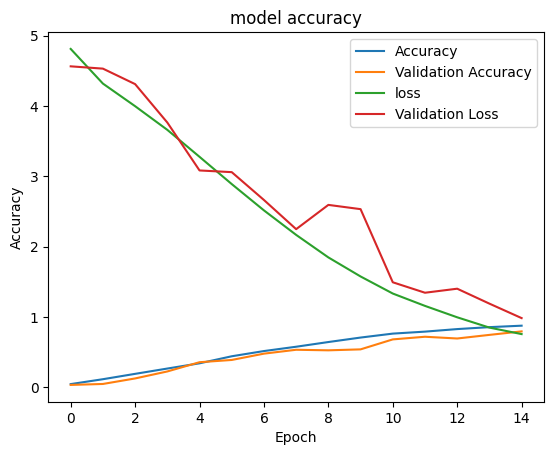

In [13]:
import matplotlib.pyplot as plt
plt.plot(history_fine.history["accuracy"])
plt.plot(history_fine.history['val_accuracy'])
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

**Evaluate model on test dataset**

In [14]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

25/25 [==============================] - 3s 128ms/step - loss: 0.8204 - accuracy: 0.8300
Test Loss: 0.8203896880149841
Test Accuracy: 0.8299999833106995


Train on additional 5 epoch

In [19]:
# Unfreeze the base model
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)


Epoch 1/5
165/165 [==============================] - 146s 671ms/step - loss: 0.6624 - accuracy: 0.8842 - val_loss: 1.1840 - val_accuracy: 0.7484
Epoch 2/5
165/165 [==============================] - 110s 667ms/step - loss: 0.5775 - accuracy: 0.9006 - val_loss: 0.7120 - val_accuracy: 0.8606
Epoch 3/5
165/165 [==============================] - 110s 669ms/step - loss: 0.5173 - accuracy: 0.9114 - val_loss: 0.5584 - val_accuracy: 0.8774
Epoch 4/5
165/165 [==============================] - 108s 652ms/step - loss: 0.4574 - accuracy: 0.9212 - val_loss: 0.5638 - val_accuracy: 0.8822
Epoch 5/5
165/165 [==============================] - 110s 666ms/step - loss: 0.4103 - accuracy: 0.9244 - val_loss: 0.6413 - val_accuracy: 0.8590


In [20]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

25/25 [==============================] - 3s 111ms/step - loss: 0.5322 - accuracy: 0.8838
Test Loss: 0.5321664214134216
Test Accuracy: 0.8837500214576721


**Save the model**

In [24]:
from keras.models import load_model

model.save('flowers_efficientnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
